In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  print('using GDrive')
except Exception as e:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
using GDrive


# Introduction 

## Data

First load the dataset:

In [7]:
from data_utils import get_mnist

train_dataset, test_dataset = get_mnist(normalize=True)

In [8]:
train_dataset.data.mean(), train_dataset.data.std()

(tensor(-6.2411e-10), tensor(0.9563))

In [9]:
train_dataset.data.min(), train_dataset.data.max()

(tensor(-1.2742), tensor(244.9449))

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Setup

Below one can find flags that will setup the notebook:

In [11]:
# Whether to tune the hyperparameters in this notebook
# Note that this might take a long time (especially for Adam)
hyperparameter_tune_minibatch = False
hyperparameter_tune_nesterov = False
hyperparameter_tune_adam = False
prot_hyperparameter_tune = False

In [12]:
# Whether to use the GPU, if it's not available, this will be ignored
use_cuda = True
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
print("Device chosen is {}".format(device))

Device chosen is cuda


We setup the training parameters that we will use all along the notebook, in order to improve readability in downstream code:

In [13]:
from training import accuracy

training_config = {
    # Loss function
    'loss_fun': torch.nn.CrossEntropyLoss(),
    # Performance evaluation function
    'metric_fun': accuracy,
    # The device to train on
    'device': device,
    # Number of epochs
    'epochs': 10,
}

test_config = training_config.copy()
test_config.pop('epochs');

Note that we will use a model with a 10-dimensional output, where each output is passed through softmax. When receiving an output 

$$Z = \begin{bmatrix} \mathbf z_1 & \dots & \mathbf z_B \end{bmatrix}^\top \in \mathbb R^{B \times 10}$$

with $B$ the batch size, we first retrieve the maximal component of each $\mathbf z_i$:

$$\hat y_i = \text{argmax}_{k = 1, \ldots, 10} \; z_{ik}, \quad i = 1, \ldots, B$$

and then compute the accuracy:

$$\text{acc} = \frac 1 B \sum_{i=1}^B I\left\{ \hat y_i = y_i \right\} $$

with $I$ the indicator function and $y_i \in \{1, \ldots, 10\}$ the true target. 

```python
def accuracy(yhat, y):
    prediction = yhat.argmax(dim=1)
    return (y.eq(prediction)).to(float).mean().item()
```

# Model

We use a simple standard model for the MNIST dataset (can be found [here](https://github.com/floydhub/mnist/blob/master/ConvNet.py)).

In [14]:
from net import Net

```python
class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

# Hyperparameter tuning on naive models

In [15]:
from training import tune_optimizer
from optimizer import AdamOptimizer, NesterovOptimizer, MiniBatchOptimizer
from data_utils import get_best_hyperparams

If the `hyperparameter_tune` flag was set to `True` above, the following code will run hyperparameter tuning on all optimizers (this takes a long time). However, this will only use a coarse grid (what we refer to "Round 1" in the notebook [Hyperparameter-tuning.ipynb](Hyperparameter-tuning.ipynb)). Since there is no programmatic way to iteratively refine the grid (this requires a lot of data visualization at each round), the tuning performed below will not end up with the same values as we used for the report, and models will perform worse.

If the flag is set to `False`, the cell at the end of this section will simply load the hyperparameters (from a file) that we carefully cross-validated.

## Adam

In [16]:
search_grid_adam = {
    'lr': np.logspace(-4, -2, 3),
    'beta1':  np.linspace(.1, .9, 3),
    'beta2': np.linspace(0.5, .999, 3),
    'batch_size': [64],
    'weight_decay': np.logspace(-4, 0, 3),
    'epsilon': np.logspace(-10, -8, 3),
}

if hyperparameter_tune_adam:
    results_adam = tune_optimizer(
        model=Net().to(device),
        optim_fun=AdamOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_adam,
        nfolds=3,
        **training_config)
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_adam_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_adam, f, indent=2)

## Nesterov

In [17]:
search_grid_nesterov = {
    'lr': np.logspace(-5, -1, 15),
    'batch_size': [64]
}

if hyperparameter_tune_nesterov:
    results_nesterov = tune_optimizer(
        model=Net().to(device),
        optim_fun=NesterovOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_nesterov,
        nfolds=3,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/nesterov_tuning_round2.json', 'w', encoding ='utf8') as f:
        json.dump(results_nesterov, f, indent=2)

## Minibatch

In [18]:
search_grid_mini  = {
    'lr': np.logspace(-3, 1., 16),
    'batch_size': [32, 64, 128],
    'decreasing_lr': [0, 1],
}
if hyperparameter_tune_minibatch:
    results_mini = tune_optimizer(
        model=Net().to(device),
        optim_fun=MiniBatchOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_mini,
        nfolds=3,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/minibatch_tuning_round2.json', 'w', encoding ='utf8') as f:
        json.dump(results_mini, f, indent=2)

## Load hyperparmeters

In [19]:
optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/adam_tuning_round3.json'),
    NesterovOptimizer: get_best_hyperparams('./res/nesterov_tuning_round2.json'),
    MiniBatchOptimizer: get_best_hyperparams('./res/minibatch_tuning_round2.json')
}

In [20]:
for o, e in optimizers.items():
    print(f'{str(o):<40}test acc = {e["metric_test"]:.3}{"":<10}test acc std = {e["metric_test_std"]:.3}')

<class 'optimizer.AdamOptimizer'>       test acc = 0.987          test acc std = 0.00074
<class 'optimizer.NesterovOptimizer'>   test acc = 0.988          test acc std = 0.00101
<class 'optimizer.MiniBatchOptimizer'>  test acc = 0.989          test acc std = 0.000235


# Attack on naive model



In [21]:
from data_utils import build_data_loaders
from training import training, testing
from adversary import attack, projected_attack

In [22]:
optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/adam_tuning_round3.json', get_performance=False),
    NesterovOptimizer: get_best_hyperparams('./res/nesterov_tuning_round2.json', get_performance=False),
    MiniBatchOptimizer: get_best_hyperparams('./res/minibatch_tuning_round2.json', get_performance=False)
}
optimizers

{optimizer.AdamOptimizer: {'batch_size': 32,
  'beta1': 0.9,
  'beta2': 0.999,
  'epsilon': 1e-08,
  'lr': 8e-05,
  'weight_decay': 0.01},
 optimizer.MiniBatchOptimizer: {'batch_size': 128,
  'decreasing_lr': False,
  'lr': 0.26389342601937466},
 optimizer.NesterovOptimizer: {'batch_size': 64, 'lr': 5e-05}}

The pipeline is as follows:

1. Loop over optimizers and their hyperparameters
    1. Instantiate data loaders
    1. Loop over repetitions
        1. Instantiate network and optimizer instances
        1. Train & Test model
        1. Attack the model over different $\epsilon$ values

In [23]:
# Logging data structures
data_naive = list()
data_naive_attack = list()

# Training / attack config
n_try = 3
batch_log_interval = -1
epsilons = np.arange(0, 0.6, 0.05)

for optimizer, optimizer_params in optimizers.items():
    print(f'--- {optimizer.__name__}')
    # --------- SETUP OPTIMIZER
    optimizer_params = optimizer_params.copy()
    # Instantiate data loaders with selected batch size
    batch_size = int(optimizer_params.pop('batch_size'))
    train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)
    
    # --------- Train & Attack several times per optimizer
    for n in range(1, n_try + 1):
        net = Net().to(device)
        optimizer_instance = optimizer(net.parameters(), **optimizer_params)
        # --------- TRAIN MODEL
        loss_train, acc_train = training(
            model=net, 
            dataset=train_loader, 
            optim=optimizer_instance,
            batch_log_interval=batch_log_interval,
            **training_config
        )
        # --------- TEST MODEL
        loss_test, acc_test = testing(
            model=net,
            dataset=test_loader,
            **test_config
        )
        # Log
        data_naive.append({
            'optimizer': str(optimizer_instance),
            'n': n,
            'loss_train': loss_train,
            'acc_train': acc_train,
            'loss_test': loss_test,
            'acc_test': acc_test
        })

        # --------- ATTACK MODEL
        print(f'Launching attacks', end=' ')
        for eps in epsilons:
            print('', end='.')
            loss_attack, acc_attack = attack(
                model=net,
                test_loader=test_loader,
                epsilon=eps,
                verbose=False,
                **test_config
            )
            # Log
            data_naive_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'attack': 'fgsm',
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })
            # Attack 2
            print('', end='.')
            loss_attack, acc_attack = projected_attack(model=net,
                                                       test_loader=test_loader, 
                                                       epsilon=eps, 
                                                       alpha=0.1, 
                                                       num_iter=40,
                                                       verbose=False,
                                                       **test_config)
            # Log
            data_naive_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'attack': 'pgd',
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })

        print()

--- AdamOptimizer
Launching training on cuda . . . . . . . . . . training took 53.82 s
Avg test loss = 0.0342	Avg test acc = 0.99
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 53.65 s
Avg test loss = 0.0359	Avg test acc = 0.989
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 53.49 s
Avg test loss = 0.0302	Avg test acc = 0.99
Launching attacks ........................
--- NesterovOptimizer
Launching training on cuda . . . . . . . . . . training took 22.22 s
Avg test loss = 0.0375	Avg test acc = 0.988
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 22.19 s
Avg test loss = 0.0511	Avg test acc = 0.984
Launching attacks ........................
Launching training on cuda . . . . . . . . . . training took 22.25 s
Avg test loss = 0.0429	Avg test acc = 0.987
Launching attacks ........................
--- MiniBatchOptimizer
Lau

### Training curves

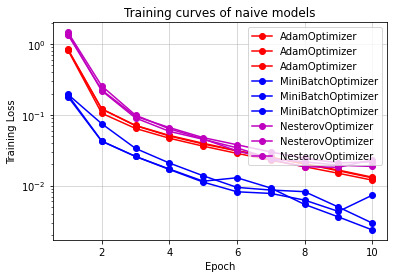

In [24]:
df_naive = pd.DataFrame(data_naive).sort_values(['optimizer', 'n'])
# Average training loss per epoch
df_naive.loss_train = df_naive.loss_train.apply(lambda s: np.mean(s, axis=1))

colors = {'AdamOptimizer': 'r', 'MiniBatchOptimizer': 'b', 'NesterovOptimizer': 'm'}
for _, row in df_naive.iterrows():
    plt.plot(range(1, training_config['epochs'] + 1), row.loss_train, '-o', label=row.optimizer, color=colors[row.optimizer])

plt.grid(alpha=.6)
plt.legend();
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Training Loss')
plt.title('Training curves of naive models');

Let's do some sanity check / monitoring:

In [25]:
df_naive['acc_mean'] = df_naive.acc_test.apply(lambda e: np.mean(e))
df_naive['acc_std'] = df_naive.acc_test.apply(lambda e: np.std(e))

In [26]:
df_naive.groupby(['optimizer'])[['acc_mean', 'acc_std']].agg('mean')

,acc_mean,acc_std
optimizer,,
AdamOptimizer,0.989450,0.020135
MiniBatchOptimizer,0.990374,0.011067
NesterovOptimizer,0.986399,0.017920


### Attack plots

In [27]:
df = pd.DataFrame(data_naive_attack).sort_values(['optimizer', 'epsilon'])
df.T.to_json('res/log_attack_naive.json', indent=2)

In [28]:
# Sanity check
df[df.epsilon== 0].groupby(['optimizer', 'attack']).acc.agg(['mean', 'std'])

mean       std
optimizer          attack                    
AdamOptimizer      fgsm    0.989450  0.000634
                   pgd     0.989450  0.000634
MiniBatchOptimizer fgsm    0.990374  0.000702
                   pgd     0.990374  0.000702
NesterovOptimizer  fgsm    0.986399  0.001836
                   pgd     0.986399  0.001836

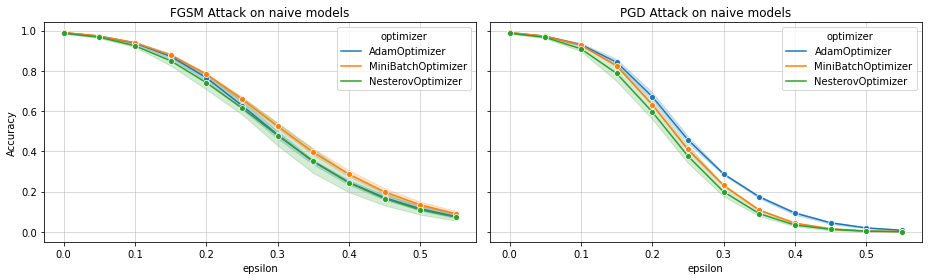

In [29]:
_, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=True, sharey=True)
plt.axes(ax[0])
sns.lineplot(x='epsilon', y='acc', data=df[df.attack == 'fgsm'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('FGSM Attack on naive models');

plt.axes(ax[1])
sns.lineplot(x='epsilon', y='acc', data=df[df.attack == 'pgd'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('PGD Attack on naive models');
plt.tight_layout()

# Attack on robust model

## Hyperparameter optimization on robust models


### Adam

In [30]:
search_grid_adam = {
    'lr': np.linspace(0.001, 0.01, 2),
    'beta1':  np.linspace(0.1, 0.9, 2),
    'beta2': np.linspace(0.5, 0.999, 2),
    'batch_size': [32, 64, 128],
    'weight_decay': np.linspace(0.001, 0.1, 2),
    'epsilon': np.linspace(1e-10, 1e-8, 2),
}

if prot_hyperparameter_tune:
    results_adam_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=AdamOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_adam,
        nfolds=3,
        func=protected_training,
        **training_config)
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_adam_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_adam_prot, f, indent=2)

### Nesterov

In [31]:
search_grid_nesterov = {
    'lr': np.logspace(0, 1),
    'batch_size': [32, 64, 128]
}

if prot_hyperparameter_tune:
    results_nesterov_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=NesterovOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,
        search_grid=search_grid_nesterov,
        nfolds=3,
        func=protected_training,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_nesterov_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_nesterov_prot, f, indent=2)

### Minibatch

In [32]:
search_grid_mini  = {
    'lr': np.linspace(0.00001, 0.01, 5),
    'batch_size': [32, 64, 128],
    'decreasing_lr': [0, 1],
}

if prot_hyperparameter_tune:
    results_mini_prot = tune_optimizer(
        model=Net().to(device),
        optim_fun=MiniBatchOptimizer,
        xtrain=train_dataset.data,
        ytrain=train_dataset.targets,                           
        search_grid=search_grid_mini,
        nfolds=3,
        func=protected_training,
        **training_config
    )
    # Overwrite the last round that we saved in a file
    with open('./res/prot_res_minibatch_new1.json', 'w', encoding ='utf8') as f:
        json.dump(results_mini_prot, f, indent=2)

### Load results

In [33]:
prot_optimizers = {
    AdamOptimizer: get_best_hyperparams('./res/prot_res_adam_new1.json', get_performance=False),
    NesterovOptimizer: get_best_hyperparams('./res/prot_res_nesterov_new2.json', get_performance=False),
    MiniBatchOptimizer: get_best_hyperparams('./res/prot_res_minibatch_new2.json', get_performance=False)
}

In [34]:
prot_optimizers

{optimizer.AdamOptimizer: {'batch_size': 128,
  'beta1': 0.9,
  'beta2': 0.999,
  'epsilon': 1e-10,
  'lr': 0.001,
  'weight_decay': 0.001},
 optimizer.MiniBatchOptimizer: {'batch_size': 64,
  'decreasing_lr': 0,
  'lr': 0.004641588833612777},
 optimizer.NesterovOptimizer: {'batch_size': 128,
  'lr': 2.6826957952797274e-05}}

## Train & Attack robust models

In [35]:
from adversary import protected_training

In [36]:
# Logging data structures
data_robust = list()
data_robust_attack = list()

# Training / attack config
n_try = 3
batch_log_interval = -1
epsilons = np.arange(0, 0.6, 0.05)

for optimizer, optimizer_params in prot_optimizers.items():
    print(f'--- {optimizer.__name__}')
    # --------- SETUP OPTIMIZER
    optimizer_params = optimizer_params.copy()
    # Instantiate data loaders with selected batch size
    batch_size = int(optimizer_params.pop('batch_size'))
    train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)

    # --------- Train & Attack several times per optimizer
    for n in range(1, n_try + 1):
        net = Net().to(device)
        optimizer_instance = optimizer(net.parameters(), **optimizer_params)
        # --------- TRAIN MODEL
        loss_train, acc_train = protected_training(
            model=net,
            dataset=train_loader,
            optim=optimizer_instance,
            batch_log_interval=batch_log_interval,
            **training_config
        )
        # --------- TEST MODEL
        loss_test, acc_test = testing(
            model=net,
            dataset=test_loader,
            **test_config
        )
        # Log
        data_robust.append({
            'optimizer': str(optimizer_instance),
            'n': n,
            'loss_train': loss_train,
            'acc_train': acc_train,
            'loss_test': loss_test,
            'acc_test': acc_test
        })

        # --------- ATTACK MODEL
        print(f'Launching attacks', end=' ')
        for eps in epsilons:
            # Attack 1
            print('', end='.')
            loss_attack, acc_attack = attack(
                model=net,
                test_loader=test_loader,
                epsilon=eps,
                verbose=False,
                **test_config
            )
            # Log
            data_robust_attack.append({
                'optimizer': str(optimizer_instance),
                'attack': 'fgsm',
                'n': n,
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })
            # Attack 2            
            print('', end='.')
            loss_attack, acc_attack = projected_attack(model=net,
                                                       test_loader=test_loader, 
                                                       epsilon=eps, 
                                                       alpha=0.01, 
                                                       num_iter=40,
                                                       verbose=False,
                                                       **test_config)
            # Log
            data_robust_attack.append({
                'optimizer': str(optimizer_instance),
                'n': n,
                'attack': 'pgd',
                'epsilon': eps,
                'loss': loss_attack,
                'acc': acc_attack
            })
        print()

--- AdamOptimizer
. . . . . . . . . . training took 25.51 s
Avg test loss = 0.0324	Avg test acc = 0.992
Launching attacks ........................
. . . . . . . . . . training took 25.13 s
Avg test loss = 0.0314	Avg test acc = 0.991
Launching attacks ........................
. . . . . . . . . . training took 25.24 s
Avg test loss = 0.0272	Avg test acc = 0.992
Launching attacks ........................
--- NesterovOptimizer
. . . . . . . . . . training took 23.63 s
Avg test loss = 0.0444	Avg test acc = 0.987
Launching attacks ........................
. . . . . . . . . . training took 23.63 s
Avg test loss = 0.0446	Avg test acc = 0.987
Launching attacks ........................
. . . . . . . . . . training took 23.7 s
Avg test loss = 0.0468	Avg test acc = 0.984
Launching attacks ........................
--- MiniBatchOptimizer
. . . . . . . . . . training took 32.05 s
Avg test loss = 0.0533	Avg test acc = 0.983
Launching attacks ........................
. . . . . . . . . . training took 3

### Training curves

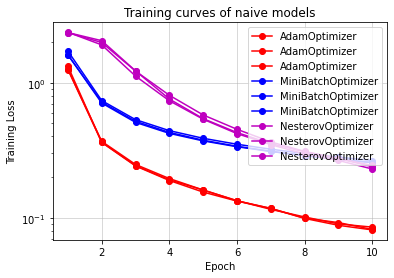

In [37]:
df_naive = pd.DataFrame(data_robust).sort_values(['optimizer', 'n'])
# Average training loss per epoch
df_naive.loss_train = df_naive.loss_train.apply(lambda s: np.mean(s, axis=1))

colors = {'AdamOptimizer': 'r', 'MiniBatchOptimizer': 'b', 'NesterovOptimizer': 'm'}
for _, row in df_naive.iterrows():
    plt.plot(range(1, training_config['epochs'] + 1), row.loss_train, '-o', label=row.optimizer, color=colors[row.optimizer])

plt.grid(alpha=.6)
plt.legend();
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Training Loss')
plt.title('Training curves of naive models');

### Attack plots

In [38]:
df_robust = pd.DataFrame(data_robust_attack).sort_values(['optimizer', 'epsilon'])
df_robust.T.to_json('res/log_attack_robust.json', indent=2)

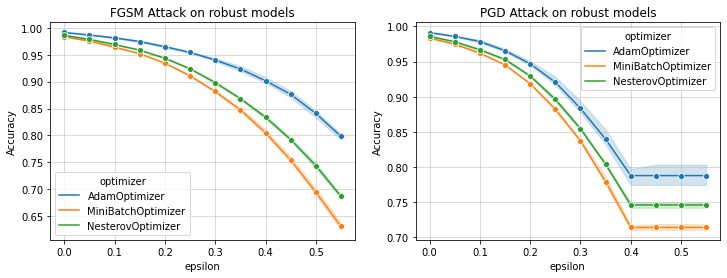

In [39]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.axes(ax[0])
# Raw accuracy in function of attack stength
sns.lineplot(x='epsilon', y='acc', data=df_robust[df_robust.attack == 'fgsm'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('FGSM Attack on robust models');

plt.axes(ax[1])
# Raw accuracy in function of attack stength
sns.lineplot(x='epsilon', y='acc', data=df_robust[df_robust.attack == 'pgd'], hue='optimizer', marker='o')
plt.grid(alpha=.6)
plt.ylabel('Accuracy');
plt.title('PGD Attack on robust models');

# Comparative analysis

In [48]:
%%capture --no-stderr
# Whether to generate fancy plots for the report. Warning: this lengthens image rendering time
# This requires the `ipypublish` library
fancy_plots = True

if fancy_plots:
    from ipypublish import nb_setup
    plt = nb_setup.setup_matplotlib()
    # Override with seaborn defaults
    sns.set(style='whitegrid')

In [49]:
from pathlib import Path

fig_path = Path('fig')
if not fig_path.exists():
    fig_path.mkdir()

In [50]:
df_naive = pd.read_json('res/log_attack_naive.json').T
df_robust = pd.read_json('res/log_attack_robust.json').T
# For some reason this has to be done after parsing from json
df_naive.epsilon = df_naive.epsilon.astype(float)
df_naive.acc = df_naive.acc.astype(float)
df_robust.acc = df_robust.acc.astype(float)
df_robust.epsilon = df_robust.epsilon.astype(float)

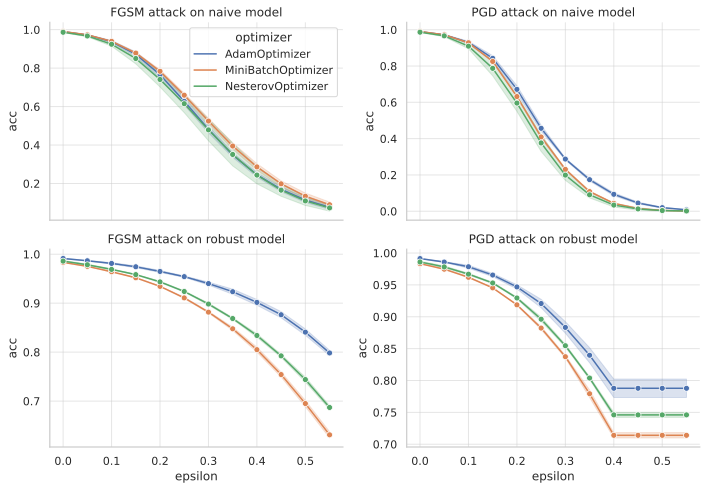

In [51]:
_, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

plot_config = [
    [df_naive, ('FGSM', 'naive'), ('PGD', 'naive')],
    [df_robust, ('FGSM', 'robust'), ('PGD', 'robust')]
]

for i, row in enumerate(plot_config):
    df = row[0]
    for j, (attack, naiveness) in enumerate(row[1:]):
        plt.axes(ax[i, j])
        sns.lineplot(x='epsilon', y='acc', data=df[df.attack == attack.lower()], hue='optimizer', marker='o', ci='sd')
        ax[i, j].set_title(f'{attack} attack on {naiveness} model')
        ax[i, j].grid(alpha=.5)
        
        if not (i == 0 and j == 0):
            ax[i, j].legend_.remove()
            
plt.tight_layout()
sns.despine()

In [52]:
join_on = ['optimizer', 'attack', 'epsilon', 'n']
df_compare = df_naive.rename(columns={'acc': 'acc_naive'}).drop(columns=['loss']) \
                     .join(df_robust.rename(columns={'acc': 'acc_robust'})\
                                    .set_index(join_on)\
                                    .drop(columns=['loss']), on=join_on)

df_compare['delta'] = df_compare.acc_robust - df_compare.acc_naive
df_compare

,optimizer,n,attack,epsilon,acc_naive,acc_robust,delta
0,AdamOptimizer,1,fgsm,0.00,0.989816,0.991594,0.001778
1,AdamOptimizer,1,pgd,0.00,0.989816,0.991594,0.001778
24,AdamOptimizer,2,fgsm,0.00,0.988718,0.990605,0.001887
25,AdamOptimizer,2,pgd,0.00,0.988718,0.990605,0.001887
48,AdamOptimizer,3,fgsm,0.00,0.989816,0.991693,0.001877
...,...,...,...,...,...,...,...
95,NesterovOptimizer,1,pgd,0.55,0.002289,0.746440,0.744151
118,NesterovOptimizer,2,fgsm,0.55,0.056131,0.682555,0.626425
119,NesterovOptimizer,2,pgd,0.55,0.000199,0.741891,0.741692
142,NesterovOptimizer,3,fgsm,0.55,0.073248,0.688390,0.615142


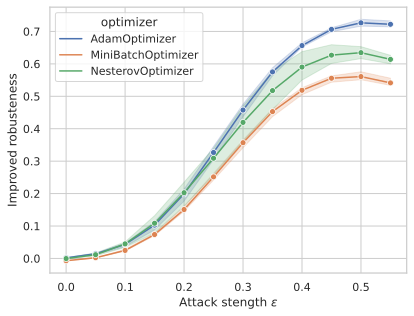

In [55]:
sns.lineplot(x='epsilon', y='delta', data=df_compare[df_compare.attack=='fgsm'], hue='optimizer', marker='o')
plt.xlabel('Attack stength $\epsilon$')
plt.ylabel('Improved robusteness')
plt.savefig('fig/robusteness.pdf', bbox_inches='tight')

Text(0, 0.5, 'Improved robusteness')

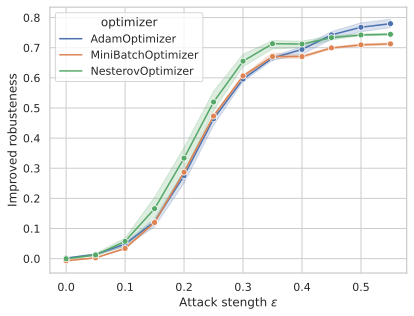

In [56]:
sns.lineplot(x='epsilon', y='delta', data=df_compare[df_compare.attack=='pgd'], hue='optimizer', marker='o')
plt.xlabel('Attack stength $\epsilon$')
plt.ylabel('Improved robusteness')